# Information about the data

First give a brief introduction to all attributes in the dataset we use:

*People*

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

*Products*

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

*Promotion*

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

*Place*

- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month


# Loading data 

In [37]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
import seaborn as sns
import scipy
import random
import math
from scipy.stats.mstats import winsorize
from tqdm import tqdm


from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import svm

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

color_palette = 'rocket'
color = '#B5838D'


In [2]:
# Importing the data from csv
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Preprocessing

In [4]:
# Check nmull values in the data
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

As we only have 24 missing values from the Income feature, we opt to fill these NA with the mean income of all the data.

In [5]:
# Compute the mean income
mean_income = np.mean(df['Income'])

# Replace the missing values with the mean
df['Income'].fillna(mean_income, inplace = True)

In [6]:
# Let's now check the how many unique values there are per feature
df_uniques = pd.DataFrame(
    data = df.nunique().sort_values(0)
)
df_uniques.rename(columns = {0: 'Unique Values'}, inplace = True)
df_uniques

,Unique Values
Z_Revenue,1
Z_CostContact,1
Response,2
AcceptedCmp3,2
AcceptedCmp4,2
AcceptedCmp2,2
Complain,2
AcceptedCmp1,2
AcceptedCmp5,2
Kidhome,3


As we can see, the first two features, <span style="color:green">Z_Revenue</span> and <span style="color:green">Z_CostContact</span>, have constant values. We will drop them as they don't provide any useful information.

- Binary Variables: <span style="color:green">Response</span> and <span style="color:green">AcceptedCmp1, 2, ...</span>

- Categorical Variables: <span style="color:green">Marital_Status</span> and <span style="color:green">Education</span>

- Discrete Ordinal Variables: <span style="color:green">Kidhome</span> and <span style="color:green">Teenhome</span>

- Continous Ordinal Variables: the rest of the variables

Also, <span style="color:green">ID</span> and <span style="color:green">Dt_Customer</span> are  pretty much useless for our tasks in this notebook, so let's drop them aswell.

In [7]:
# Dropping the constant features
df.drop(['Z_Revenue', 'Z_CostContact', 'ID', 'Dt_Customer'], axis = 1, inplace = True)

In [8]:
# Changing some units so it's easier for us               
# # Change date of birth to age  
df['Age'] = 2021 - df.Year_Birth.to_numpy()         
df.drop('Year_Birth', axis = 1, inplace = True)

# Change units to 1K$
df['Income'] = df['Income'] / 1000

We see that, for the <span style="color:green">Marital_Status</span> feature, we have 8 different values, which seems a lot of different values that may not offer useful information and might affect on the posterior classifications. Let's analyse it: 

In [9]:
# See the Marital_status values
df['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [10]:
# Alone, Absurd and YOLO can be put in the same category as Single
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')

Let's analyse the <span style="color:green">Education</span> feature:

In [11]:
# Count the different values of Education 
df['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

There are 5 different levels of education, but 2nd Cycle is equal to Master according to the 'Three Cycle System'.

In [12]:
# Replace 2nd Cycle by Master
df['Education'].replace(['2nd Cycle'], 'Master', inplace = True)

## Outliers

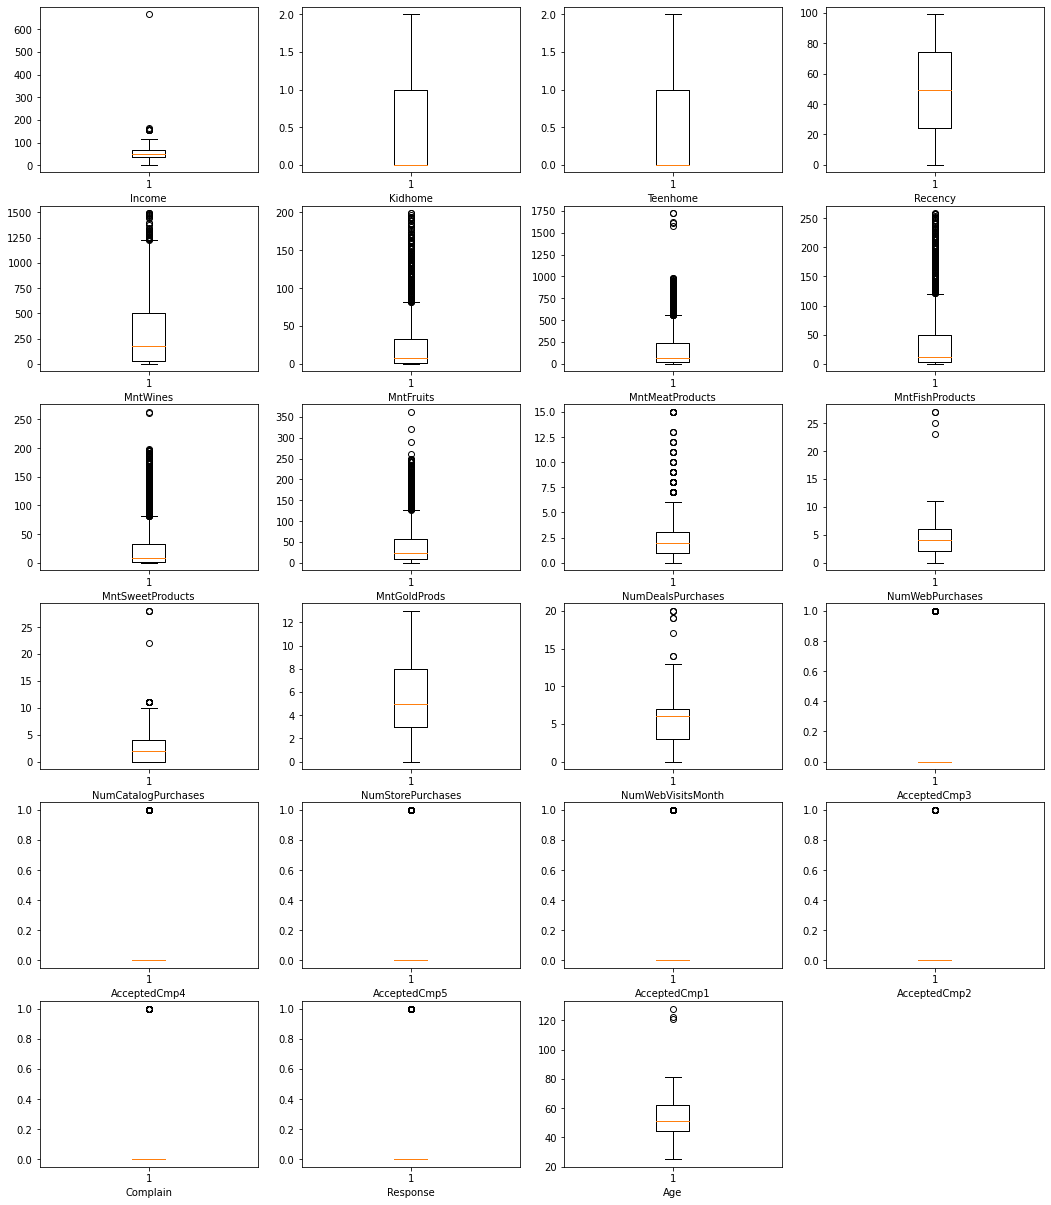

In [13]:
# Let's plot all the numerical features son we can analyse if tehre are outliers that need processing

# Get the numerical values
num_columns = df.select_dtypes(include = np.number).columns.tolist()

# PLot the boxplots for each feature
j = 1
fig = plt.figure(figsize = (18, 25))
for col in num_columns:
    plt.subplot(7,4,j)
    plt.boxplot(df[col])
    j += 1
    plt.xlabel(col)
plt.show()

As on a first look it may seem that we have a lot of outliers, the only ones that really need our attention are the ones on the <span style="color:green">Age</span> and <span style="color:green">Income</span> features. 

- <span style="color:green">Age</span>: remove rows with ages greater than 100 years.
- <span style="color:green">Income</span>: remove rows with incomes greater than 200K.

In [14]:
# Previous number of rows
prev_rows = df.shape[0]

# Remove Age outliers
df.drop(df[df['Age'] > 100].index, inplace = True)

# Remove Income outliers
df.drop(df[df['Income'] > 200].index, inplace = True)

# Number of rows
rows = df.shape[0]

# How many rows we have dropped
print(f'We have dropped {prev_rows-rows} rows.')

We have dropped 4 rows.


# Data analysis

### Age distribution

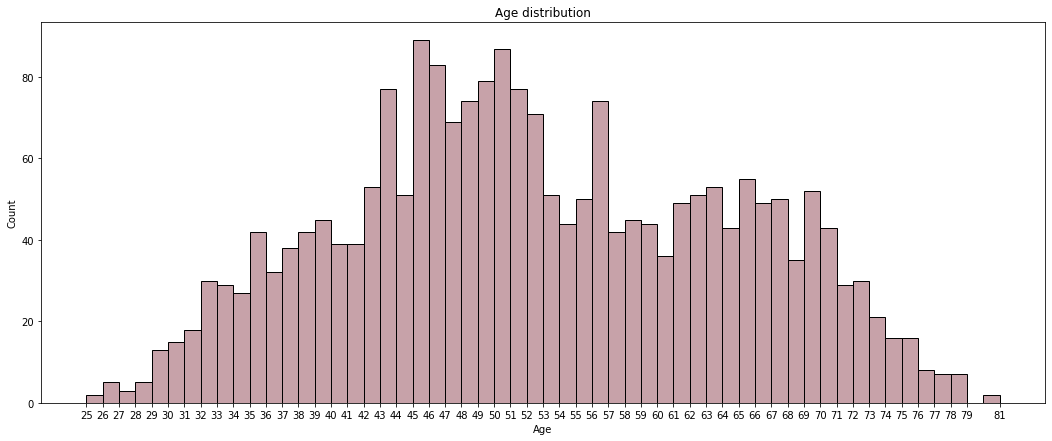

In [38]:
# Plot the age distribution
plt.figure(figsize = (18, 7))
ax = sns.histplot(df['Age'].sort_values(), bins = 56, color = color)
# ax = sns.histplot(df, x = 'Age', bins = 56, palette = color_palette, hue = 'Education')

plt.title('Age distribution')
plt.xticks(np.linspace(df['Age'].min(), df['Age'].max(), 56, dtype=int, endpoint = True))
plt.show()

There are very few people under 30. Most of the customers are on the 40 to 70 range. With those values, we expect tha most of the people don't have the single <span style="color:green">Marital_status</span> value. Let's check it: